In [1]:
import pandas as pd
import numpy as np
import sys, gc, os

In [2]:
os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 'data',
 'files.dat',
 'files_tcga.dat',
 'lung.ipynb',
 'mainTable_all.csv',
 'TCGAbiolinks_LUAD.csv',
 'TCGAbiolinks_LUSC.csv',
 'topsbm']

In [60]:
df_meta = pd.read_csv("TCGAbiolinks_LUAD.csv", index_col=0).sort_index().append(pd.read_csv("TCGAbiolinks_LUSC.csv", index_col=0).sort_index(), sort=False)
df_meta["Age.at.diagnosis"] = df_meta["Age.at.diagnosis"].replace("[Not Available]",np.nan)
df_meta["Age.at.diagnosis"] = df_meta["Age.at.diagnosis"].astype(float)
bins = np.linspace(df_meta["Age.at.diagnosis"].min(),df_meta["Age.at.diagnosis"].max(), 4)
df_meta["Age.at.diagnosis"] = pd.cut(df_meta["Age.at.diagnosis"],bins,labels=bins[1:])

df_meta.columns

Index(['Sex', 'Age.at.diagnosis', 'T.stage', 'N.stage', 'Tumor.stage',
       'Smoking.Status', 'Survival', 'Transversion.High.Low',
       'Nonsilent.Mutations', 'Nonsilent.Mutations.per.Mb',
       'Oncogene.Negative.or.Positive.Groups', 'Fusions', 'expression_subtype',
       'chromosome.affected.by.chromothripsis', 'iCluster.Group',
       'CIMP.methylation.signature.',
       'MTOR.mechanism.of.mTOR.pathway.activation', 'Ploidy.ABSOLUTE.calls',
       'Purity.ABSOLUTE.calls', 'M.stage', 'Pack.years', 'Nonsilent.Mutatios',
       'Nonsilent.Mutatios.per.Mb', 'Selected.Mutation.Summary',
       'High.Level.Amplifications', 'Homozygous.Deletions',
       'Expression.Subtype'],
      dtype='object')

In [61]:
df_tcgabiolinks = pd.read_csv("../TCGA_biolinks.csv", index_col=0).dropna(how="all", axis=1)
df_tcgabiolinks = df_tcgabiolinks[df_tcgabiolinks["cancer.type"].isin(["LUAD","LUSC"])].set_index("pan.samplesID")
df_tcgabiolinks

,cancer.type,Subtype_mRNA,Subtype_DNAmeth,Subtype_protein,Subtype_miRNA,Subtype_CNA,Subtype_Integrative,Subtype_other,Subtype_Selected
pan.samplesID,,,,,,,,,
TCGA-05-4249,LUAD,NaN,NaN,NaN,NaN,NaN,5,NaN,LUAD.5
TCGA-05-4382,LUAD,NaN,NaN,NaN,NaN,NaN,6,NaN,LUAD.6
TCGA-05-4384,LUAD,NaN,low,NaN,NaN,NaN,1,NaN,LUAD.1
TCGA-05-4389,LUAD,NaN,NaN,NaN,NaN,NaN,2,NaN,LUAD.2
TCGA-05-4390,LUAD,NaN,intermediate,NaN,NaN,NaN,2,NaN,LUAD.2
...,...,...,...,...,...,...,...,...,...
TCGA-70-6722,LUSC,secretory,NaN,NaN,NaN,NaN,NaN,NaN,LUSC.secretory
TCGA-70-6723,LUSC,classical,NaN,NaN,NaN,NaN,NaN,NaN,LUSC.classical
TCGA-85-6175,LUSC,secretory,NaN,NaN,NaN,NaN,NaN,NaN,LUSC.secretory


In [62]:
df_files=pd.read_csv("files_tcga.dat", index_col=0)
df_files=df_files.drop_duplicates("cases.0.submitter_id")
df_files.sort_values('cases.0.submitter_id', inplace=True)

bins = np.linspace(0,5,num=4)
cutted = pd.cut(df_files["cases.0.samples.0.longest_dimension"].replace("unknown", np.nan).dropna().astype(float),bins=bins, labels=bins[1:])
df_files["longest_dimension"]=df_files["cases.0.samples.0.longest_dimension"]
df_files["longest_dimension"][cutted.index]=cutted

df_files=df_files[df_files['cases.0.submitter_id'].isin(df_meta.index)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [72]:
pd.read_csv("../TCGA_biolinks.csv", index_col=0)["cancer.type"].unique()

array(['ACC', 'AML', 'BLCA', 'BRCA', 'LGG', 'GBM', 'ESCA', 'COAD', 'STAD',
       'READ', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LIHC', 'LUAD', 'LUSC',
       'OVCA', 'PCPG', 'PRAD', 'SKCM', 'THCA', 'UCEC', 'UCS'],
      dtype=object)

In [64]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id').transpose().append(df_meta.reset_index().set_index('patient').reindex(index=df_files['cases.0.submitter_id']).transpose()).transpose().reset_index().set_index("file_name")

In [65]:
df_files = df_files.reset_index().set_index('cases.0.submitter_id')
df_files = df_files.transpose().append(df_tcgabiolinks.reindex(index=df_files.index).transpose()).transpose()

In [66]:
df_files.dropna(how="any", axis=1, thresh=len(df_files.index)/10, inplace=True)

In [67]:
df_files=df_files.fillna("unknown").set_index("file_name")
df_files.to_csv("files.dat", index=True, header=True)

In [37]:
df = pd.read_csv("mainTable_all.csv",index_col=0)

In [42]:
df.columns[~df.columns.isin(df_files.index)]

Index(['7d079b75-6da9-4e35-b0b0-7dbc68fbf0d0.FPKM.txt.gz',
       '50dcf6f0-fce9-45aa-af88-116313aa3936.FPKM.txt.gz',
       '3dd9e081-d183-49b4-8d67-afa513496f21.FPKM.txt.gz',
       '00068002-f4f0-4610-bfe6-67169c760d21.FPKM.txt.gz',
       '1edd3b8b-2a9c-43f9-a20e-ca564a37d3aa.FPKM.txt.gz',
       'c897eb81-97e5-4007-9d85-66aa2c565f0e.FPKM.txt.gz',
       'e7bacb69-34d7-476d-a124-5d015bec383d.FPKM.txt.gz',
       '0263a550-8b66-4884-b014-99501112741d.FPKM.txt.gz',
       'cfcc9019-4d83-44ec-840c-684f7664bdc7.FPKM.txt.gz',
       '8df93787-af1e-4b07-afa1-f910eda02a1c.FPKM.txt.gz',
       ...
       'e4de8f87-b9c8-4021-b29a-b7d128ff64a3.FPKM.txt.gz',
       '1208db51-3816-4c68-8b01-b494b14063cf.FPKM.txt.gz',
       '7b4a2fcb-95eb-4cc2-8fde-ec0851ffb724.FPKM.txt.gz',
       '808353e4-59a3-4df0-90fd-bd42b7af366e.FPKM.txt.gz',
       'db0ce49b-0048-4ba2-9295-309d8c570bb4.FPKM.txt.gz',
       '186b83bd-ec3f-42b4-ba91-d86c9618d5e3.FPKM.txt.gz',
       '8dd3161b-a1d9-453c-afb8-293b20330f3d.

In [44]:
df = df.reindex(columns=df.columns[df.columns.isin(df_files.index)])
df.to_csv("mainTable.csv", index=True, header=True)
df_files.fillna("unknown").to_csv("files.dat", index=True)

In [45]:
import scanpy as sc

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


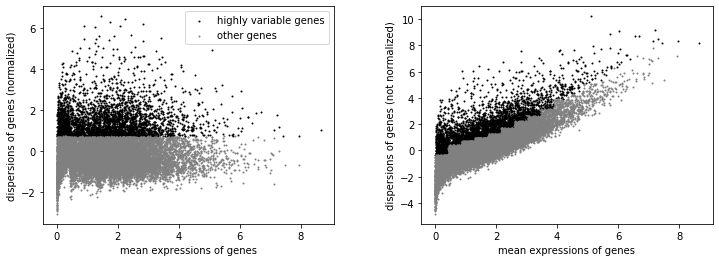

In [48]:
adata = sc.AnnData(X=df.transpose(), obs=df_files.reindex(index=df.columns))
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pl.highly_variable_genes(adata)
hvg = adata.var[adata.var["highly_variable"]==True].index

In [49]:
df.reindex(index=hvg).to_csv("mainTable.csv", index=True, header=True)

In [32]:
from sbmtm import sbmtm

/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: /home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/graph_tool/draw/libgraph_tool_draw.so: undefined symbol: _ZN5Cairo7Context9show_textERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warnings.warn(msg, RuntimeWarning)


In [59]:
hsbm = sbmtm()

In [60]:
hsbm.make_graph_from_BoW_df(df.reindex(index=hvg))

In [61]:
hsbm.save_graph("graph_hv.xml.gz")

In [62]:
del hsbm
gc.collect()

4562